Import libraries

In [1]:
import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sys
from pathlib import Path

parent_dir = Path.cwd().parent.parent

if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.metrics import print_evaluation_metrics
from shared.helpers import store_model

Load dataset and prepare df

In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date"
target_column = "Close"
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column]]

df = df.groupby(date_column).sum().reset_index()
df.set_index(date_column, inplace=True)
df = df.dropna()
dates = df.index.values

Train test split

In [3]:
data_length = len(df)
train_split = 0.9
train = df.iloc[:int(data_length*train_split)]
test = df.iloc[int(data_length*train_split):]

Parameter tuning for order and seasonal order

In [4]:
stepwise_fit = auto_arima(
    df[target_column],
    trace=True,
    suppress_warnings=True,
    max_P=3,
    max_D=2,
    max_Q=3,
    m=12,
    stepwise=True,
)
best_order = stepwise_fit.order
best_seasonal_order = stepwise_fit.seasonal_order

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=54893.203, Time=28.98 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=54939.395, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=54931.077, Time=2.26 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=54932.170, Time=1.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=54938.255, Time=0.09 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=54919.893, Time=20.49 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=54916.805, Time=18.18 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=54891.141, Time=54.27 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=54902.977, Time=37.66 sec
 ARIMA(2,1,2)(3,0,1)[12] intercept   : AIC=54900.071, Time=112.93 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=54880.947, Time=57.31 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=54891.059, Time=52.72 sec
 ARIMA(2,1,2)(3,0,2)[12] intercept   : AIC=54886.418, Time=134.83 sec
 ARIMA(2,1,2)(2,0,3)[12] intercept   : AIC=inf, Time=111.78 sec
 ARIMA(2,1,2)(1,0,3)[12] intercept   : AI

Create Model

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    train[target_column], order=best_order, seasonal_order=best_seasonal_order
)
model = model.fit()
model.summary()

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.08960D+00    |proj g|=  2.47870D-02


 This problem is unconstrained.



At iterate    5    f=  8.08856D+00    |proj g|=  5.02883D-03

At iterate   10    f=  8.08849D+00    |proj g|=  4.15801D-03

At iterate   15    f=  8.08846D+00    |proj g|=  4.65465D-04

At iterate   20    f=  8.08840D+00    |proj g|=  6.07474D-03

At iterate   25    f=  8.08638D+00    |proj g|=  5.79228D-03

At iterate   30    f=  8.08612D+00    |proj g|=  3.30196D-03

At iterate   35    f=  8.08600D+00    |proj g|=  8.68864D-04

At iterate   40    f=  8.08583D+00    |proj g|=  5.76491D-04

At iterate   45    f=  8.08580D+00    |proj g|=  8.02495D-04

At iterate   50    f=  8.08538D+00    |proj g|=  2.11573D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                 3056
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 12)   Log Likelihood              -24708.913
Date:                            Mon, 01 Apr 2024   AIC                          49435.825
Time:                                    14:05:20   BIC                          49490.046
Sample:                                10-17-2014   HQIC                         49455.310
                                     - 02-27-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8750      0.024     78.390      0.000       1.828       1.922
ar.L2         -0.9461      0.023    -41.459      0.000      -0.991      -0.901
ma.L1         -1.8801      0.022    -85.908      0.000      -1.923      -1.837
ma.L2          0.9547      0.021     45.674      0.000       0.914       0.996
ar.S.L12      -1.7335      0.033    -53.016      0.000      -1.798      -1.669
ar.S.L24      -0.8511      0.029    -29.809      0.000      -0.907      -0.795
ma.S.L12       1.6722      0.035     48.459      0.000       1.605       1.740
ma.S.L24       0.8051      0.031     26.377      0.000       0.745       0.865
sigma2       6.32e+05   5785.124    109.244      0.000    6.21e+05    6.43e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):             32430.41
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):            1067.58   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Plot the result

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


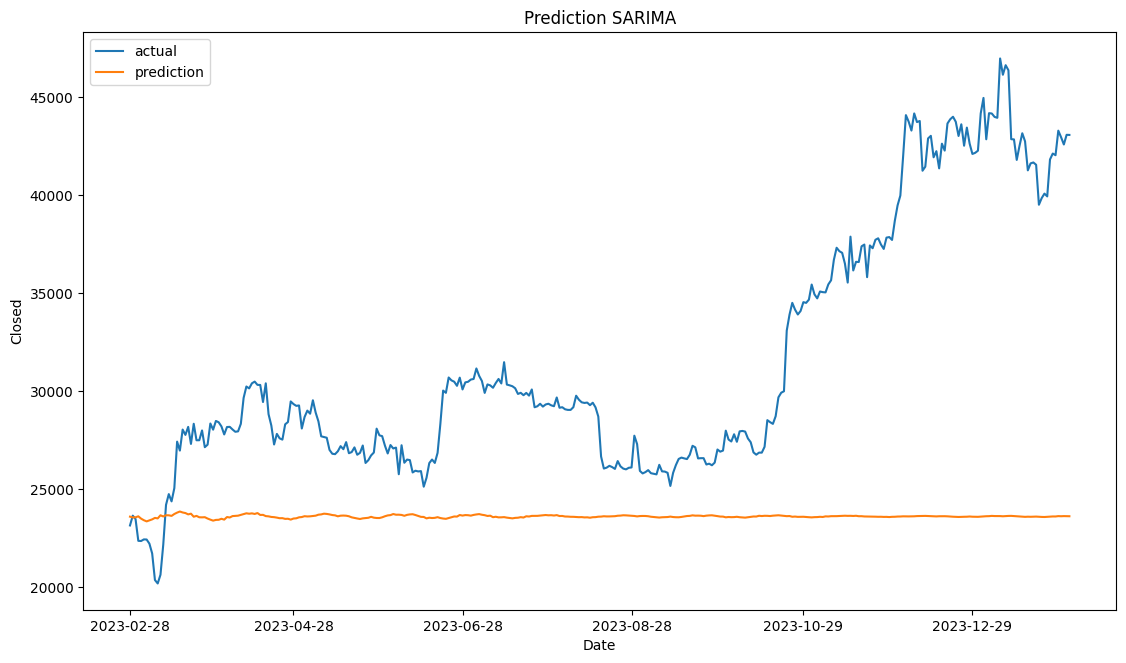

In [10]:
start = len(train)
end = len(train) + len(test) - 1
pred = model.predict(start=start, end=end, typ="levels")

fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(dates[int(data_length*train_split):], test[target_column].values, label="actual")
ax.plot(dates[int(data_length*train_split):], list(pred), label="prediction")
ax.set_title("Prediction SARIMA")
ax.set_ylabel("Closed")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

RMSE of the result

In [11]:
print_evaluation_metrics(pred, test[target_column])

Evaluation Metrics:
MSE: 101690983.09
RMSE: 10084.19
MAE: 7954.22
MAPE: nan
SMAPE: nan


In [12]:
store_model(model, "sarima")